# Phase 1

# Boulder: Twitter & Covid-19

Even though cases of Covid-19 have increased rapidly in the past couple months, I have noticed that a growing sentiment of people is that they simply do not care about the virus anymore. For example, despite the rapid transmission levels, many people are still participating in large gatherings. I have noticed this behavior as a stark contrast to back in March and April when people took the virus very seriously, despite the much lower amount of cases. Essentially what I am getting at is that people have been growing tired of dealing with covid life and the restrictions on their social activities that this causes. As a result, people have seemed to be returning to normalish levels of activity. 

Knowing this, I would like to explore how people's sentiment of Covid-19 has changed over time. The perfect way of doing this is through Twitter data. In this project I plan to analyze how often people talk about covid, who talks about covid the most, and if people talk about covid in relation to case numbers. Specifically, I will be looking at twitter accounts that are CU Boulder and Boulder County affiliated.

Research Question: Have tweets about Covid-19 decreased over time even though cases have increased?

## Step One: Covid Data

In [6]:
import requests
import json

import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import datetime as datetime
import csv

To gather our Covid-19 data for Boulder County we will be using the CDPHE COVID19 County-Level Open Data Repository. Instead of downloading this data to my machine, I will be using an API call.

In [10]:
req = requests.request('GET', 'https://opendata.arcgis.com/datasets/52fb11a8a07f49c1b28335a9de9ba99f_0.geojson')
response_json = json.loads(req.text)
response_json["features"]

[{'type': 'Feature',
  'properties': {'COUNTY': 'LOGAN',
   'LABEL': 'Logan',
   'FULL_': 'Logan County',
   'FIPS': '075',
   'POP': 21854,
   'Desc_': 'Cases of COVID-19 in Colorado by County',
   'Metric': 'Cases',
   'Value': 2,
   'Rate': None,
   'Date': '03/23/2020',
   'ObjectId': 1},
  'geometry': None},
 {'type': 'Feature',
  'properties': {'COUNTY': 'MESA',
   'LABEL': 'Mesa',
   'FULL_': 'Mesa County',
   'FIPS': '077',
   'POP': 153630,
   'Desc_': 'Cases of COVID-19 in Colorado by County',
   'Metric': 'Cases',
   'Value': 2,
   'Rate': None,
   'Date': '03/23/2020',
   'ObjectId': 2},
  'geometry': None},
 {'type': 'Feature',
  'properties': {'COUNTY': 'MONTROSE',
   'LABEL': 'Montrose',
   'FULL_': 'Montrose County',
   'FIPS': '085',
   'POP': 42260,
   'Desc_': 'Cases of COVID-19 in Colorado by County',
   'Metric': 'Cases',
   'Value': 1,
   'Rate': None,
   'Date': '03/23/2020',
   'ObjectId': 3},
  'geometry': None},
 {'type': 'Feature',
  'properties': {'COUNTY': 

In [ ]:
req = requests.request('GET', 'https://opendata.arcgis.com/datasets/1456d8d43486449292e5784dcd9ce4a7_0.geojson')
response_json = json.loads(req.text)
response_json["features"]

This gives us data on all counties, as well as multiple different metrics, so we will filter down to Boulder and create our own dataframe with the cases metric.

In [11]:
list_of_dates = []
list_of_cases = []
for data in response_json["features"]:
    if data["properties"]["COUNTY"] == "BOULDER":
        if data["properties"]["Metric"] == "Cases":
            list_of_dates.append(data["properties"]["Date"])
            list_of_cases.append(data["properties"]["Value"])

In [12]:
boco_cases_df = pd.DataFrame({"Date": list_of_dates,
                             "Cases": list_of_cases})

In [14]:
boco_cases_df.drop(boco_cases_df.tail(1).index,inplace=True) # drop December 1st
boco_cases_df

,Date,Cases
0,03/24/2020,49
1,03/17/2020,8
2,03/20/2020,16
3,03/23/2020,39
4,03/18/2020,7
...,...,...
254,11/26/2020,10495
255,11/27/2020,10669
256,11/28/2020,10793
257,11/29/2020,10926


In [15]:
boco_cases_df["Date"] = pd.to_datetime(boco_cases_df["Date"])
boco_cases_df.head()

,Date,Cases
0,2020-03-24,49
1,2020-03-17,8
2,2020-03-20,16
3,2020-03-23,39
4,2020-03-18,7


Text(0.5, 1.0, 'Boulder County Covid-19 Cases Over Time')

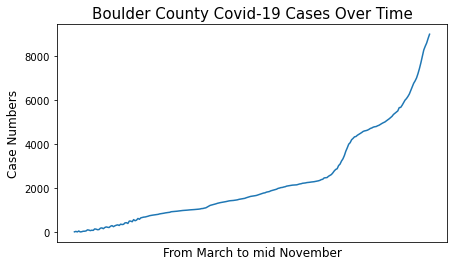

In [404]:
fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(boco_cases_df["Cases"])

ax.get_xaxis().set_ticks([])

plt.xlabel("From March to mid November",fontsize=12)
plt.ylabel("Case Numbers",fontsize=12)
plt.title("Boulder County Covid-19 Cases Over Time",fontsize=15)

## Step Two: Twitter Data

We will be using the Tweepy API to gather data from Twitter.

In [1]:
import getpass

In [2]:
key = getpass.getpass()

········


In [3]:
secret_key = getpass.getpass()

········


In [4]:
access = getpass.getpass()

········


In [5]:
secret_access = getpass.getpass()

········


In [6]:
import tweepy

# Authenticate to Twitter
auth = tweepy.OAuthHandler(key, 
    secret_key)
auth.set_access_token(access, secret_access)

api = tweepy.API(auth)

# Check keys
try:
    api.verify_credentials()
    print("Authentication OK")
except:
    print("Error during authentication")

Authentication OK


In [9]:
# set keys for future calls
auth = tweepy.OAuthHandler(key, secret_key)
auth.set_access_token(access, secret_access)

In [10]:
# create API object
api = tweepy.API(auth, wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

Now that we are setup we need to begin collecting some tweets to build into a dataframe.

The following code block copied largely from this source with a few modifications. These modifications were to ge the full tweet text and to only get tweets up until January 1st 2020.

https://gist.github.com/yanofsky/5436496

In [252]:
def get_all_tweets(screen_name):
    #Twitter only allows access to a users most recent 3240 tweets with this method
    
    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(key, secret_key)
    auth.set_access_token(access, secret_access)
    api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)
    
    #initialize a list to hold all the tweepy Tweets
    alltweets = []  
    
    #make initial request for most recent tweets (200 is the maximum allowed count)
    new_tweets = api.user_timeline(screen_name = screen_name,count=200, tweet_mode="extended")
    
    #save most recent tweets
    alltweets.extend(new_tweets)
    
    #MODIFIY
    #save the id of the oldest tweet less one
    oldest = alltweets[-1].id - 1
    oldest_date = alltweets[-1].created_at
    
    #MODIFY
    #keep grabbing tweets until there are no tweets left to grab
    while oldest_date > datetime.datetime(2020, 1, 1):      #len(new_tweets) > 0:
       # print(f"getting tweets before {oldest_date}")
        
        #all subsiquent requests use the max_id param to prevent duplicates
        # I had to change mode to extended to get the full tweets
        new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest,tweet_mode="extended")
        
        #save most recent tweets
        alltweets.extend(new_tweets)
        
        #update the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1
        oldest_date = alltweets[-1].created_at
        
       # print(f"...{len(alltweets)} tweets downloaded so far")
    
    #transform the tweepy tweets into a 2D array that will populate the csv 
    outtweets = [[tweet.id_str, tweet.created_at, tweet.full_text] for tweet in alltweets] 
    
    #write the csv  
    with open(f'new_{screen_name}_tweets.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["id","created_at","text"])
        writer.writerows(outtweets)
    
    pass

In [177]:
get_all_tweets("bouldercounty")

In [13]:
boco_tweets_df = pd.read_csv("new_bouldercounty_tweets.csv")
boco_tweets_df.head()

,id,created_at,text
0,1329518812279037954,2020-11-19 20:16:00,Cone Zones: US 287 &amp; Isabelle Road Interse...
1,1329148422906130433,2020-11-18 19:44:13,RT @BoCoClimate: Boulder County released its #...
2,1329131376726183937,2020-11-18 18:36:28,RT @BoCoTripTracker: Happy Ruby Bridges Walk t...
3,1329130926966759429,2020-11-18 18:34:41,RT @bouldercohealth: Due to ongoing increases ...
4,1328796627293888517,2020-11-17 20:26:18,"Thursday, 11/19, at 2 p.m. @corestassoc is hos..."


What can we do with this data? How can we track how much people are talking about Covid-19 through tweets?

We can do this through making a word bank of Covid-19 vocabulary and checking how many times these words appear in the tweets.

In [14]:
# Hashtags are accounted for in the function

wordBank = ["coronavirus","virus","covid-19","COVID-19","covid",
            "pandemic","epidemic", "quarantine","isolate","isolation",
           "corona","social distancing","social distant","cases","mask","masks","6 feet",
            "six feet","sanitizer","wash","health","home","safer","exposure","exposed"]

def calculateCoronaMentions(tweet):
    count=0
    for word in tweet.split():
        if word.lower() in wordBank or word.lower()[1:] in wordBank: # this accounts for hashtags
            count +=1
    return(count)

In [16]:
# test our function
calculateCoronaMentions("mask quarantine CoviD #mAsKs -- none of these words")

4

Now we can create a column in the dataframe that tells us how many "covid mentions" are in each tweet.

In [17]:
boco_tweets_df["Covid Mentions"] = boco_tweets_df["text"].apply(calculateCoronaMentions)

In [18]:
# how many total mentions this year?
print("The @bouldercounty Twitter account has tweeted {} covid mentions this year.".format(
    boco_tweets_df["Covid Mentions"].sum(axis=0)))
print()
print("Since @bouldercounty has tweeted {0} times, this averages out to {1} covid mentions per tweet".format(
    len(boco_tweets_df.index),boco_tweets_df["Covid Mentions"].sum(axis=0)/len(boco_tweets_df.index)))

The @bouldercounty Twitter account has tweeted 86 covid mentions this year.

Since @bouldercounty has tweeted 400 times, this averages out to 0.215 covid mentions per tweet


Since we can successfully do these calculations on one twitter account. Let's now gather data on many twitter accounts, all relating to Boulder or CU Boulder, in order to compare the accounts.

We are going to create an intensive function that will help create our dataframe that we will use for the rest of the project. Among many different things here is what this function will accomplish:
* Looping through a list of twitter accounts
* creating a csv file and a dataframe for each account
* Reformatting the dataframe by dropping columns and converting dates to datetime objects
* Performing a groupby by month and creating aggregations that sum the number of covid mentions per month and count the number of tweets per month
* Creating a new variable that calculates covid mentions per tweet on a monthly basis
* Reformatting into a multiindex dataframe with the user and month as the two indicies
* Finally, concatenating the multiple smaller dataframes into one large dataframe

In [23]:
def concatData(list_of_twitter_accounts):
    list_of_dataframes = []
    for account in list_of_twitter_accounts:
        get_all_tweets(account)
        _df = pd.read_csv("new_"+account+"_tweets.csv")

        #Quick reformat
        _df.drop(columns=["id"],inplace=True)
        _df["created_at"] = pd.to_datetime(_df["created_at"])
        _df.rename(columns={"created_at":"Date"},inplace=True)

        _df["Month"] = _df["Date"].apply(lambda x: x.month)
        #monthly_test.index = ["CUBoulder"]

        _df["Number of Covid Mentions"] = _df["text"].apply(calculateCoronaMentions)
        #monthly_test.drop(columns=["Date","text"],inplace=True)
        _gb = _df.groupby("Month").agg({"Number of Covid Mentions":"sum",
                                            "text":"count"})

        # remove last index if there are tweets from December
        if len(_gb.index) == 12:
            _gb.drop(_gb.tail(1).index,inplace=True)

        _gb.rename(columns={"text":"Total Tweets"},inplace=True)
        _gb["user"] = account
        _gb["Mentions Per Tweet"] = _gb["Number of Covid Mentions"]/_gb["Total Tweets"]


        # reindex - i used this documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html
        arrays = [[account for i in range(0,11)], # may be issue
              [item for item in _gb.index]]
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=['User', 'Month'])
        _gb.index = index
        _gb.drop(columns=["user"],inplace=True)
        
        list_of_dataframes.append(_gb)
       # print(_gb)
    
    # concat to big dataframe
    boulder_tweets = pd.concat(list_of_dataframes)
   # boulder_tweets.to_csv("boulder_tweets_2.csv")
    return(boulder_tweets)


To create our dataframe I have collected a list of 15 twitter accounts that I believe are the most important or the most interesting related to Boulder. Due to the rate limit of the Twitter API I can only do so many requests per 15 minutes. As a result I had to split up the accounts into different lists to run at different periods of time. This is a bit messy but was necessary for the API.

In [402]:
# Have to split up because Twitter only allows so many api calls in a given time period

list_of_accounts = [
    "CUBoulder",
    "CUMarkKennedy",
    "CUBoulderPolice",
    "CUBuffs"
]

second_list_of_accounts = [
    "CUBoulderLife",
    "bouldercounty",
    "bouldercohealth"
]

third_list_of_accounts = [
    "bouldernews"
]

third_part_2 = [
    "bldrCOSheriff"
]
third_part_3 = [
    "BoulderCh1News"
]

fourth_list_of_accounts = [
    "BoulderChamber",
    "downtownboulder",
    "boulderparksrec"
]

fifth_list_of_accounts = [
    "ColoradoStateU",
    "GovofCO"
]

In [313]:
boulder_tweets = concatData(list_of_accounts)

In [314]:
boulder_tweets

Number of Covid Mentions  Total Tweets  \
User            Month                                           
CUBoulder       1                             4           191   
                2                             1           238   
                3                            50           351   
                4                            40           317   
                5                            24           323   
                6                            15           171   
                7                            30           188   
                8                            50           242   
                9                           130           366   
                10                           98           377   
                11                           55           324   
CUMarkKennedy   1                             4            41   
                2                             0            45   
                3                            10            27   
                4                             5            22   
                5                             8            29   
                6                             0            23   
                7                             1            26   
                8                             2            28   
                9                             5            43   
                10                            2            44   
                11                            4            37   
CUBoulderPolice 1                             2            40   
                2                             0            13   
                3                             7            16   
                4                             8            20   
                5                            10            27   
                6                             8            25   
                7                             1            27   
                8                             0            44   
                9                             2            42   
                10                            1            72   
                11                            0            45   
CUBuffs         1                            10           120   
                2                            14           165   
                3                            11           168   
                4                            32           213   
                5                             5           169   
                6                             2            83   
                7                            13            83   
                8                             6            68   
                9                             7            85   
                10                            6            93   
                11                           13            82   

                       Mentions Per Tweet  
User            Month                      
CUBoulder       1                0.020942  
                2                0.004202  
                3                0.142450  
                4                0.126183  
                5                0.074303  
                6                0.087719  
                7                0.159574  
                8                0.206612  
                9                0.355191  
                10               0.259947  
                11               0.169753  
CUMarkKennedy   1                0.097561  
                2                0.000000  
                3                0.370370  
                4                0.227273  
                5                0.275862  
                6                0.000000  
                7                0.038462  
                8                0.071429  
                9                0.116279  
                10               0.045455  
                11  

In [345]:
boulder_tweets_2 = concatData(second_list_of_accounts)

In [39]:
boulder_tweets_2

Number of Covid Mentions  Total Tweets  \
User            Month                                           
CUBoulderLife   1                             1            48   
                2                             4            88   
                3                            16            95   
                4                            11            88   
                5                             8            56   
                6                             3            72   
                7                            13            95   
                8                            32           146   
                9                            39           180   
                10                           20           141   
                11                           18           135   
bouldercounty   1                             0            22   
                2                             1            19   
                3                            27            76   
                4                            14            44   
                5                            10            21   
                6                             5            12   
                7                             8            30   
                8                             1            50   
                9                             2            27   
                10                           14            59   
                11                            4            31   
bouldercohealth 1                            18            28   
                2                             7            13   
                3                            58            88   
                4                            26            26   
                5                            22            29   
                6                            39            49   
                7                            38            57   
                8                            42            87   
                9                            77            80   
                10                           55            81   
                11                           38            47   
boulderweekly   1                             1            67   
                2                             2            65   
                3                             5            69   
                5                             7            16   
                6                             1            26   
                7                             2            32   
                8                            11            57   
                9                             4            51   
                10                            4            48   
                11                            6            92   
                12                            3            77   

                       Mentions Per Tweet  
User            Month                      
CUBoulderLife   1                0.020833  
                2                0.045455  
                3                0.168421  
                4                0.125000  
                5                0.142857  
                6                0.041667  
                7                0.136842  
                8                0.219178  
                9                0.216667  
                10               0.141844  
                11               0.133333  
bouldercounty   1                0.000000  
                2                0.052632  
                3                0.355263  
                4                0.318182  
                5                0.476190  
                6                0.416667  
                7                0.266667  
                8                0.020000  
                9                0.074074  
                10               0.237288  
                11  

In [265]:
boulder_tweets_3 = concatData(third_list_of_accounts)

In [271]:
boulder_tweets_3_2 = concatData(third_part_2)

In [277]:
boulder_tweets_3_3 = concatData(third_part_3)

In [257]:
boulder_tweets_4 = concatData(fourth_list_of_accounts)

In [346]:
boulder_tweets_5 = concatData(fifth_list_of_accounts)

Concatenate to create full dataframe

In [347]:
new_boulder_tweets = pd.concat([boulder_tweets,boulder_tweets_2,boulder_tweets_3,boulder_tweets_3_2,boulder_tweets_3_3,boulder_tweets_4,boulder_tweets_5])
new_boulder_tweets.to_csv("complete_boulder_tweets.csv")

In [348]:
new_boulder_tweets

Number of Covid Mentions  Total Tweets  Mentions Per Tweet
User      Month                                                            
CUBoulder 1                             4           191            0.020942
          2                             1           238            0.004202
          3                            50           351            0.142450
          4                            40           317            0.126183
          5                            24           323            0.074303
...                                   ...           ...                 ...
GovofCO   7                            13            26            0.500000
          8                             5            22            0.227273
          9                             9            28            0.321429
          10                           13            66            0.196970
          11                           15            21            0.714286

[165 rows x 3 columns]

We have now collected and organized a full dataframe of twitter data from 15 different accounts all relating to Boulder. 

## Step 3: Merge the Data

Let's prepare the Covid data for the merge. Since our twitter data is monthly, we will need to do the same thing with our covid data.

In [399]:
boco_gb = boco_cases_df.copy()
boco_gb["Month"] = boco_gb["Date"].apply(lambda x: x.month)
boco_gb_mean = boco_gb.groupby("Month").agg({"Cases":"mean"})
boco_gb_total = boco_gb.groupby("Month").agg({"Cases":"sum"})

boco_gb_mean.reset_index(inplace=True)
boco_gb_total.reset_index(inplace=True)

Since we included twitter data from January and Feburary in order to see the before and after of covid, we will need to add in two rows for these months into our covid data.

In [400]:
jan = pd.DataFrame({"Month":datetime.datetime(1,1,20).month,"Cases":0},index =[0])
feb = pd.DataFrame({"Month":datetime.datetime(2,2,20).month,"Cases":0},index =[1])

boco_gb_mean = pd.concat([jan,feb,boco_gb_mean]).reset_index(drop=True)
boco_gb_total = pd.concat([jan,feb,boco_gb_total]).reset_index(drop=True)

boco_gb_covid = boco_gb_mean.copy()

boco_gb_covid["Total Cases"] = boco_gb_total["Cases"]
boco_gb_covid.rename(columns={"Cases":"Average Cases"},inplace=True)

boco_gb_covid

,Month,Average Cases,Total Cases
0,1,0.000000,0
1,2,0.000000,0
2,3,51.400000,771
3,4,325.200000,9756
4,5,825.354839,25586
5,6,1148.300000,34449
6,7,1603.612903,49712
7,8,2125.258065,65883
8,9,3189.366667,95681
9,10,5020.677419,155641


In [401]:
merged_df = new_boulder_tweets.join(boco_gb_covid, on="Month")
merged_df["Average Cases"] = merged_df["Average Cases"].shift(1)
merged_df["Total Cases"] = merged_df["Total Cases"].shift(1)
merged_df.fillna(0,inplace=True)
merged_df.drop(columns=["Month"],inplace=True)
merged_df

Number of Covid Mentions  Total Tweets  Mentions Per Tweet  \
User      Month                                                               
CUBoulder 1                             4           191            0.020942   
          2                             1           238            0.004202   
          3                            50           351            0.142450   
          4                            40           317            0.126183   
          5                            24           323            0.074303   
...                                   ...           ...                 ...   
GovofCO   7                            13            26            0.500000   
          8                             5            22            0.227273   
          9                             9            28            0.321429   
          10                           13            66            0.196970   
          11                           15            21            0.714286   

                 Average Cases  Total Cases  
User      Month                              
CUBoulder 1           0.000000          0.0  
          2           0.000000          0.0  
          3          51.400000        771.0  
          4         325.200000       9756.0  
          5         825.354839      25586.0  
...                        ...          ...  
GovofCO   7        1603.612903      49712.0  
          8        2125.258065      65883.0  
          9        3189.366667      95681.0  
          10       5020.677419     155641.0  
          11       7302.222222     131440.0  

[165 rows x 5 columns]

## Step 4: Preliminary Findings

In [350]:
# in order to sort better by user 
merged_df = merged_df.copy().reset_index()
merged_df

,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases
0,CUBoulder,1,4,191,0.020942,0.000000,0.0
1,CUBoulder,2,1,238,0.004202,0.000000,0.0
2,CUBoulder,3,50,351,0.142450,51.400000,771.0
3,CUBoulder,4,40,317,0.126183,325.200000,9756.0
4,CUBoulder,5,24,323,0.074303,825.354839,25586.0
...,...,...,...,...,...,...,...
160,GovofCO,7,13,26,0.500000,1603.612903,49712.0
161,GovofCO,8,5,22,0.227273,2125.258065,65883.0
162,GovofCO,9,9,28,0.321429,3189.366667,95681.0
163,GovofCO,10,13,66,0.196970,5020.677419,155641.0


##### Most Total Covid Mentions

In [351]:
top_10_total = merged_df.sort_values("Number of Covid Mentions",ascending=False).head(10)
top_10_total[["User","Month","Number of Covid Mentions"]].reset_index(drop=True)

,User,Month,Number of Covid Mentions
0,CUBoulder,9,130
1,GovofCO,3,101
2,CUBoulder,10,98
3,ColoradoStateU,3,81
4,bouldercohealth,9,77
5,BoulderCh1News,3,68
6,ColoradoStateU,9,61
7,bouldercohealth,3,58
8,ColoradoStateU,8,56
9,bouldercohealth,10,55


@CUBoulder has the most tweets about covid in one month from this year in September. Number 2 is from Jared Polis back in March when the pandemic was beginning. Interestingly almost all of the most tweeted months are from either March or September/October, with nothing in the middle. 

##### Most Covid Mentions Per Tweet

In [353]:
top_per = merged_df.sort_values("Mentions Per Tweet",ascending=False).head(10)
top_per[["User","Month","Mentions Per Tweet","Total Tweets"]].reset_index(drop=True)

,User,Month,Mentions Per Tweet,Total Tweets
0,bouldercohealth,4,1.000000,26
1,bouldercohealth,9,0.962500,80
2,bouldercohealth,11,0.808511,47
3,bouldercohealth,6,0.795918,49
4,bouldercohealth,5,0.758621,29
5,GovofCO,11,0.714286,21
6,BoulderCh1News,3,0.693878,98
7,GovofCO,3,0.691781,146
8,bouldercohealth,10,0.679012,81
9,bouldercohealth,7,0.666667,57


This is not suprising. @bouldercohealth's entire job is to promote healthy and safe living. In February they tweeted 26 times and every single tweet mentioned covid. Interestingly, Governor Polis included a covid mention in 71% of his tweets this month in November which even beats his amount of 69% of tweets back in March.

#### @bouldercounty vs @CUBoulder

In [182]:
boco = merged_df[merged_df["User"]=="bouldercounty"]
boco

,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases
55,bouldercounty,1,0,22,0.000000,0.000000,0.0
56,bouldercounty,2,1,19,0.052632,0.000000,0.0
57,bouldercounty,3,27,76,0.355263,51.400000,771.0
58,bouldercounty,4,14,44,0.318182,325.200000,9756.0
59,bouldercounty,5,10,21,0.476190,825.354839,25586.0
60,bouldercounty,6,5,12,0.416667,1148.300000,34449.0
61,bouldercounty,7,8,30,0.266667,1603.612903,49712.0
62,bouldercounty,8,1,50,0.020000,2125.258065,65883.0
63,bouldercounty,9,2,27,0.074074,3189.366667,95681.0
64,bouldercounty,10,14,59,0.237288,5020.677419,155641.0


In [200]:
cu = merged_df[merged_df["User"]=="CUBoulder"]
cu

,index,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases
0,0,CUBoulder,1,4,191,0.020942,0.000000,0.0
1,1,CUBoulder,2,1,238,0.004202,0.000000,0.0
2,2,CUBoulder,3,50,351,0.142450,51.400000,771.0
3,3,CUBoulder,4,40,317,0.126183,325.200000,9756.0
4,4,CUBoulder,5,24,323,0.074303,825.354839,25586.0
5,5,CUBoulder,6,15,171,0.087719,1148.300000,34449.0
6,6,CUBoulder,7,30,188,0.159574,1603.612903,49712.0
7,7,CUBoulder,8,50,242,0.206612,2125.258065,65883.0
8,8,CUBoulder,9,130,366,0.355191,3189.366667,95681.0
9,9,CUBoulder,10,98,377,0.259947,5020.677419,155641.0


Text(0, 0.5, 'Number Of Tweets')

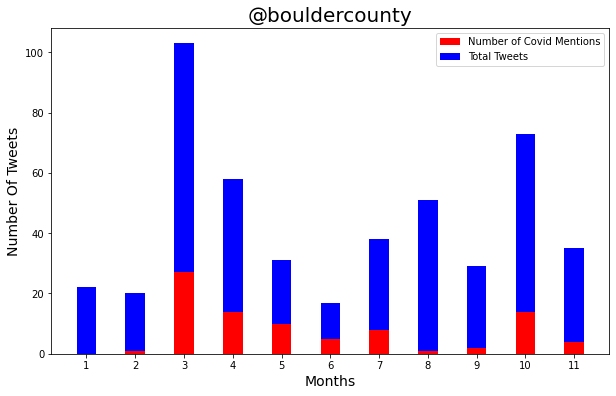

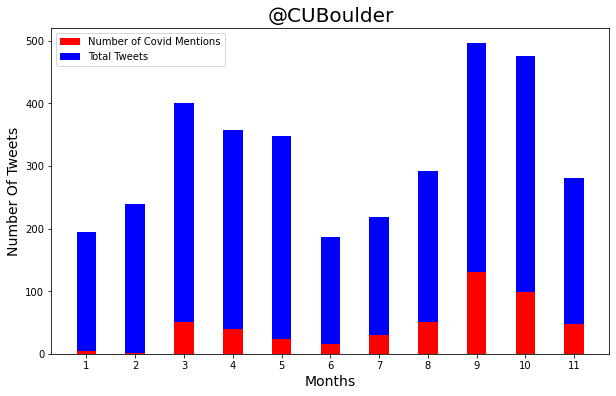

In [357]:
f, ax1 = plt.subplots(figsize=(10, 6))

plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10,11],
        rotation=0)
plt.title('@bouldercounty',fontsize=20)
plt.xlabel('Months',fontsize=14)
plt.ylabel('Number Of Tweets',fontsize=14)
plt.legend((p3[0], p4[0]), ('Number of Covid Mentions', 'Total Tweets'))

f, ax2 = plt.subplots(figsize=(10, 6))

#https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
ind = np.arange(11)
width = 0.4

plt.xticks([0,1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10,11],
        rotation=0)


p1 = ax1.bar(ind, boco["Number of Covid Mentions"], width, color='r')
p2 = ax1.bar(ind, boco["Total Tweets"], width, bottom=boco["Number of Covid Mentions"], color='b')

plt.legend((p3[0], p4[0]), ('Number of Covid Mentions', 'Total Tweets'))

p3 = ax2.bar(ind, cu["Number of Covid Mentions"], width, color='r')
p4 = ax2.bar(ind, cu["Total Tweets"], width, bottom=cu["Number of Covid Mentions"], color='b')

plt.title('@CUBoulder',fontsize=20)
plt.xlabel('Months',fontsize=14)
plt.ylabel('Number Of Tweets',fontsize=14)


Here we see that at the beginning of the pandemic in March both accounts were very active in tweeting about covid. Then they both follow the similar pattern of decreasing their amounts of covid mentions until July. This is where the two accounts start to differ. @bouldercounty had almost no tweets about covid during August and September despite the rising case numbers. Whereas @CUBoulder began tweeting heavily about covid in September, presumably because of the return of students to campus.

#### @CUBoulder vs @ColoradoStateU

In [355]:
csu = merged_df[merged_df["User"]=="ColoradoStateU"]
csu

,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases
143,ColoradoStateU,1,1,134,0.007463,0.000000,0.0
144,ColoradoStateU,2,5,199,0.025126,0.000000,0.0
145,ColoradoStateU,3,81,233,0.347639,51.400000,771.0
146,ColoradoStateU,4,46,269,0.171004,325.200000,9756.0
147,ColoradoStateU,5,36,318,0.113208,825.354839,25586.0
148,ColoradoStateU,6,22,112,0.196429,1148.300000,34449.0
149,ColoradoStateU,7,28,160,0.175000,1603.612903,49712.0
150,ColoradoStateU,8,56,225,0.248889,2125.258065,65883.0
151,ColoradoStateU,9,61,240,0.254167,3189.366667,95681.0
152,ColoradoStateU,10,35,222,0.157658,5020.677419,155641.0


Text(0.06, 0.5, 'Number of Covid Mentions')

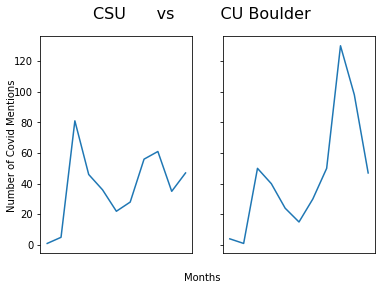

In [396]:
fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
fig.suptitle('CSU      vs         CU Boulder', fontsize=16)

ax1.plot(csu["Number of Covid Mentions"])
ax2.plot(cu["Number of Covid Mentions"])

ax1.get_xaxis().set_ticks([])
ax2.get_xaxis().set_ticks([])



fig.text(0.5, 0.04,'Months', ha='center', va='center') #https://stackoverflow.com/questions/6963035/pyplot-axes-labels-for-subplots
fig.text(0.06, 0.5, 'Number of Covid Mentions', ha='center', va='center', rotation='vertical')


Here we see that CSU back in March was tweeting more about Covid than CU. In the summer months both schools tweeted less about covid, part of this due to their total number of tweets decreasing during months with school off. However, where we see a large difference is when students came back to school in August and September when CU ramped up their levels of covid tweeting while CSU didn't even return to its high from March. According to this graph, either CU has a much bigger covid problem than CSU or they are more proactive in preaching safety guidelines and covid alerts. My bet is on the latter.

## Step 5: Hypothesis

My hypothesis is that there is a negative correlation between cases of Covid-19 and how often the virus is mentioned on twitter from our community leading people and organizations. 

# ----

# Phase 2

End result:Statement of conclusions. Your conclusions should address the answer to your research questionor whether your hypothesis was supported.  How does this knowledge line up with other knowledge orbeliefs about how the phenomenon or relationship works?  In other words, is there something surprisinghere that undermines conventional wisdom or does this support a conventional wisdom? Do they suggest anew perspective on recent events? What did we learn from your work? The conclusions should also discussthe limitations of the data and methods you used. What kinds of data, analyses, or cases might exist that couldserve as counterfactuals to the relationships you observed?

First we must reload back in the data.

In [4]:
load_new_boulder_tweets = pd.read_csv("complete_boulder_tweets.csv")
load_new_boulder_tweets

,User,Month,Number of Covid Mentions,Total Tweets,Mentions Per Tweet
0,CUBoulder,1,4,191,0.020942
1,CUBoulder,2,1,238,0.004202
2,CUBoulder,3,50,351,0.142450
3,CUBoulder,4,40,317,0.126183
4,CUBoulder,5,24,323,0.074303
...,...,...,...,...,...
160,GovofCO,7,13,26,0.500000
161,GovofCO,8,5,22,0.227273
162,GovofCO,9,9,28,0.321429
163,GovofCO,10,13,66,0.196970


In [16]:
boco_cases_df

,Date,Cases
0,2020-03-24,49
1,2020-03-17,8
2,2020-03-20,16
3,2020-03-23,39
4,2020-03-18,7
...,...,...
254,2020-11-26,10495
255,2020-11-27,10669
256,2020-11-28,10793
257,2020-11-29,10926


In [17]:
boco_gb = boco_cases_df.copy()
boco_gb["Month"] = boco_gb["Date"].apply(lambda x: x.month)
boco_gb_mean = boco_gb.groupby("Month").agg({"Cases":"mean"})
boco_gb_total = boco_gb.groupby("Month").agg({"Cases":"sum"})

boco_gb_mean.reset_index(inplace=True)
boco_gb_total.reset_index(inplace=True)

In [18]:
jan = pd.DataFrame({"Month":datetime.datetime(1,1,20).month,"Cases":0},index =[0])
feb = pd.DataFrame({"Month":datetime.datetime(2,2,20).month,"Cases":0},index =[1])

boco_gb_mean = pd.concat([jan,feb,boco_gb_mean]).reset_index(drop=True)
boco_gb_total = pd.concat([jan,feb,boco_gb_total]).reset_index(drop=True)

boco_gb_covid = boco_gb_mean.copy()

boco_gb_covid["Total Cases"] = boco_gb_total["Cases"]
boco_gb_covid.rename(columns={"Cases":"Average Cases"},inplace=True)

boco_gb_covid

,Month,Average Cases,Total Cases
0,1,0.000000,0
1,2,0.000000,0
2,3,51.400000,771
3,4,325.200000,9756
4,5,825.354839,25586
5,6,1148.300000,34449
6,7,1603.612903,49712
7,8,2125.258065,65883
8,9,3189.366667,95681
9,10,5020.677419,155641


In [103]:
merged_df = load_new_boulder_tweets.merge(boco_gb_covid, on="Month")
merged_df["Average Cases"] = merged_df["Average Cases"].shift(1)
merged_df["Total Cases"] = merged_df["Total Cases"].shift(1)
merged_df.fillna(0,inplace=True)
merged_df.drop(columns=["Month"],inplace=True)
merged_df

,User,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases
0,CUBoulder,4,191,0.020942,0.0,0.0
1,CUMarkKennedy,4,41,0.097561,0.0,0.0
2,CUBoulderPolice,2,40,0.050000,0.0,0.0
3,CUBuffs,10,120,0.083333,0.0,0.0
4,CUBoulderLife,1,48,0.020833,0.0,0.0
...,...,...,...,...,...,...
160,BoulderChamber,34,128,0.265625,8472.7,254181.0
161,downtownboulder,1,34,0.029412,8472.7,254181.0
162,boulderparksrec,5,73,0.068493,8472.7,254181.0
163,ColoradoStateU,47,188,0.250000,8472.7,254181.0


In [137]:
months = []
count = 1
for i in range(0,11):
    for b in range(0,15):
        months.append(count)
    count+=1
len(months)

165

In [104]:
merged_df["Month"] = [item for item in months]

In [105]:
merged_df["Total Cases"] = merged_df["Total Cases"].shift(-1)
merged_df.loc[164,"Total Cases"] = merged_df.loc[163,"Total Cases"]
merged_df["Average Cases"] = merged_df["Average Cases"].shift(-1)
merged_df.loc[164,"Average Cases"] = merged_df.loc[163,"Average Cases"]
merged_df[merged_df["User"]=="CUBoulder"]

,User,Number of Covid Mentions,Total Tweets,Mentions Per Tweet,Average Cases,Total Cases,Month
0,CUBoulder,4,191,0.020942,0.000000,0.0,1
15,CUBoulder,1,238,0.004202,0.000000,0.0,2
30,CUBoulder,50,351,0.142450,51.400000,771.0,3
45,CUBoulder,40,317,0.126183,325.200000,9756.0,4
60,CUBoulder,24,323,0.074303,825.354839,25586.0,5
75,CUBoulder,15,171,0.087719,1148.300000,34449.0,6
90,CUBoulder,30,188,0.159574,1603.612903,49712.0,7
105,CUBoulder,50,242,0.206612,2125.258065,65883.0,8
120,CUBoulder,130,366,0.355191,3189.366667,95681.0,9
135,CUBoulder,98,377,0.259947,5020.677419,155641.0,10


In [106]:
merged_df.to_csv("merged_complete_boulder_tweets.csv")

# Heatmap

In [44]:
covid_mentions_pivot = pd.pivot_table(merged_df,
                                      index="User",
                                      columns="Month",
                                      values="Mentions Per Tweet"
                                     )


covid_mentions_pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul',"Aug","Sep","Oct","Nov"]

covid_mentions_pivot

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov
User,,,,,,,,,,,
BoulderCh1News,0.000000,0.000000,0.693878,0.222222,0.152174,0.000000,0.068966,0.000000,0.068182,0.086420,0.083333
BoulderChamber,0.016667,0.028571,0.180851,0.386555,0.224806,0.183206,0.296703,0.247423,0.112360,0.132812,0.265625
CUBoulder,0.020942,0.004202,0.142450,0.126183,0.074303,0.087719,0.159574,0.206612,0.355191,0.259947,0.169753
CUBoulderLife,0.020833,0.045455,0.168421,0.125000,0.142857,0.041667,0.136842,0.219178,0.216667,0.141844,0.133333
CUBoulderPolice,0.050000,0.000000,0.437500,0.400000,0.370370,0.320000,0.037037,0.000000,0.047619,0.013889,0.000000
CUBuffs,0.083333,0.084848,0.065476,0.150235,0.029586,0.024096,0.156627,0.088235,0.082353,0.064516,0.158537
CUMarkKennedy,0.097561,0.000000,0.370370,0.227273,0.275862,0.000000,0.038462,0.071429,0.116279,0.045455,0.108108
ColoradoStateU,0.007463,0.025126,0.347639,0.171004,0.113208,0.196429,0.175000,0.248889,0.254167,0.157658,0.250000
GovofCO,0.265060,0.173077,0.691781,0.571429,0.232558,0.200000,0.500000,0.227273,0.321429,0.196970,0.714286


<AxesSubplot:ylabel='User'>

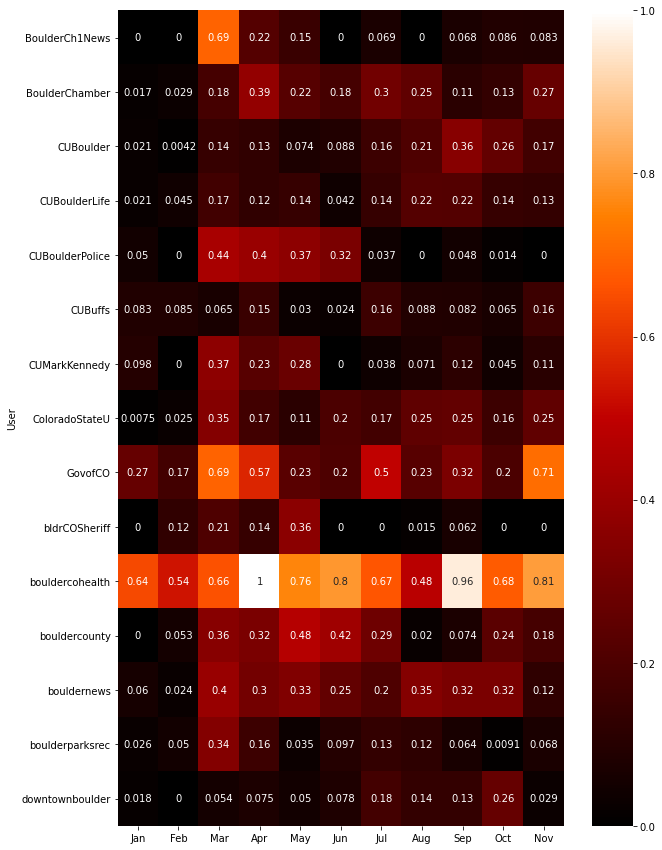

In [45]:
f,ax = plt.subplots(figsize=(10,15))
sb.heatmap(covid_mentions_pivot,ax=ax,annot=True,cmap="gist_heat")

### Aggregated Values

In [59]:
average_per_month = pd.DataFrame(covid_mentions_pivot.mean(axis=0))
average_per_month.columns = ["Average Per Month"]
average_per_month

,Average Per Month
Jan,0.087174
Feb,0.076765
Mar,0.340797
Apr,0.291841
May,0.242173
Jun,0.179721
Jul,0.202340
Aug,0.162017
Sep,0.212542
Oct,0.173860


<AxesSubplot:>

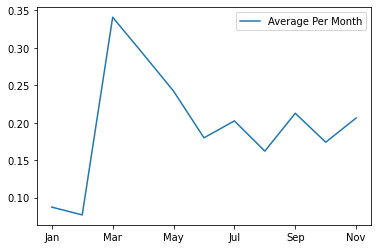

In [61]:
average_per_month.plot()

In [ ]:
# writeup

In [69]:
# Have to split up because Twitter only allows so many api calls in a given time period

total_list_of_accounts = [
    "CUBoulder",
    "CUMarkKennedy",
    "CUBoulderPolice",
    "CUBuffs",
    "CUBoulderLife",
    "bouldercounty",
    "bouldercohealth",
    "bouldernews",
    "bldrCOSheriff",
    "BoulderCh1News",
    "BoulderChamber",
    "downtownboulder",
    "boulderparksrec",
    "ColoradoStateU",
    "GovofCO"
]


In [124]:
cu = merged_df[merged_df["User"] == "CUBoulder"]

top = cu.sort_values("Mentions Per Tweet",ascending=False).head(3)
for value in top["Month"]:
    print(value)

9
10


In [129]:
list_of_users_dictionaries = []

for account in total_list_of_accounts:
    dictionary = {}
    users_df = merged_df[merged_df["User"]==account]
    top = users_df.sort_values("Mentions Per Tweet",ascending=False).head(3)
    list_of_values = []
    for value in top["Month"]:
        list_of_values.append(value)
    dictionary["User"] = account
    dictionary["Top Month"] = list_of_values[0]
    list_of_users_dictionaries.append(dictionary)
    
top_months = pd.DataFrame(list_of_users_dictionaries)

In [131]:
top_months

,User,Top Month
0,CUBoulder,9
1,CUMarkKennedy,3
2,CUBoulderPolice,3
3,CUBuffs,11
4,CUBoulderLife,8
5,bouldercounty,5
6,bouldercohealth,4
7,bouldernews,3
8,bldrCOSheriff,5
9,BoulderCh1News,3


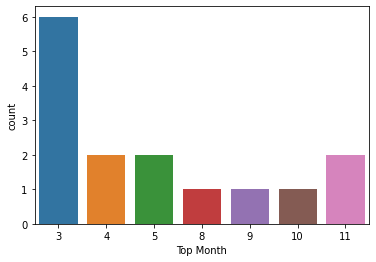

In [135]:
ax = sb.countplot(x="Top Month",data=top_months)

In [136]:
# dicuss

In [138]:
# need to do correlation thing

In [141]:
grouped_df = merged_df.groupby("Month").agg({"Number of Covid Mentions":sum,
                                            "Total Cases":"mean"})
grouped_df

,Number of Covid Mentions,Total Cases
Month,,
1,69,0.0
2,49,0.0
3,495,771.0
4,318,9756.0
5,199,25586.0
6,142,34449.0
7,198,49712.0
8,245,65883.0
9,383,95681.0


In [143]:
# get rid of january and feburary
grouped_df = grouped_df.tail(9)
grouped_df

,Number of Covid Mentions,Total Cases
Month,,
3,495,771.0
4,318,9756.0
5,199,25586.0
6,142,34449.0
7,198,49712.0
8,245,65883.0
9,383,95681.0
10,319,155641.0
11,259,254181.0


In [148]:
grouped_df["Normed Covid Mentions"] = grouped_df["Number of Covid Mentions"]/grouped_df.loc[3,"Number of Covid Mentions"]
grouped_df["Normed Cases"] = grouped_df["Total Cases"]/grouped_df.loc[3,"Total Cases"]

grouped_df

/Users/cadedannels/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/cadedannels/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Number of Covid Mentions,Total Cases,Normed Covid Mentions,Normed Cases
Month,,,,
3,495,771.0,1.000000,1.000000
4,318,9756.0,0.642424,12.653696
5,199,25586.0,0.402020,33.185473
6,142,34449.0,0.286869,44.680934
7,198,49712.0,0.400000,64.477302
8,245,65883.0,0.494949,85.451362
9,383,95681.0,0.773737,124.099870
10,319,155641.0,0.644444,201.869001
11,259,254181.0,0.523232,329.677043


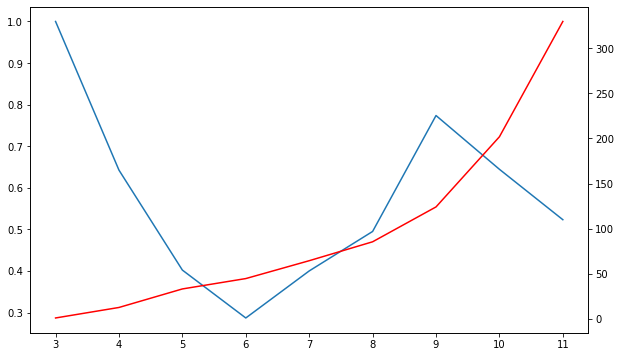

In [151]:
f, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(grouped_df["Normed Covid Mentions"])

ax2 = ax1.twinx()
ax2.plot(grouped_df["Normed Cases"],color="r")
